# Introducción

Se debe investigar el comportamiento de usuario para la aplicación de una empresa que comercializa productos alimentarios.

Primero, se estudiará el embudo de ventas para descubrir cómo los usuarios y las usuarias llegan a la etapa de compra. Para ello se formularán preguntas relacionadas al comportamiento de los clientes durante su paso por el embudo.

Luego se analizarán los resultados de un test A/A/B, realizado debiido a que al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados del test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Debemos descubrir qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

La información para el análisis general y para el análisis A/A/B está en el mismo dataset.

# Descripción de datos

Cada entrada de registro es una acción de usuario o un evento. La ruta del archivo es `/datasets/logs_exp_us.csv`.

- `EventName`: nombre del evento.
- `DeviceIDHash`: identificador de usuario unívoco.
- `EventTimestamp`: hora del evento.
- `ExpId`: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

# Pauta de trabajo

Este informe estará dividido en tres partes, cada una de ellas tendrá diferentos objetivos:

__Preanálisis:__ Etapa en la cual se cargan los datos y se optimizan en caso de ser necesario, se trabajan los valores duplicados y ausentes, y finalmente, se modifican los datos para facilitar el posterior análisis.

- Optimizar el nombre de las columnas de manera que sea conveniente para el análisis.
- Comprobar si hay tipos de datos y valores ausentes y corregir los datos si es necesario.
- Agregar una columna de fecha y hora y una columna separada para las fechas (transformar las fechas del formato timestamp).

__Análisis:__ Etapa en la cual se responden las preguntas establecidas y se trazan los gráficos correspondientes.

- Estudiar y comprobar los datos.
    - ¿Cuántos eventos hay en los registros?
    - ¿Cuántos usuarios y usuarias hay en los registros?
    - ¿Cuál es el promedio de eventos por usuario?
    - ¿Qué periodo de tiempo cubren los datos?
    - ¿Hay una cantidad suficiente de registros por grupo?
    
    
- Estudiar el embudo de eventos.
    - ¿Qué eventos hay en los registros? y ¿Cuál su frecuencia de suceso?
    - ¿Cual la cantidad de usuarios y usuarias que realizaron cada una de las acciones registradas?
    - ¿En qué orden ocurrieron las acciones?
    - ¿Cual es la proporción de usuarios y usuarias que pasan de una etapa a la siguiente?
    - ¿En qué etapa pierdes más usuarios y usuarias?
    - ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?


- Estudiar los resultados del experimento.
    - ¿Cuántos usuarios y usuarias hay en cada grupo?
    - ¿Hay una diferencia estadísticamente significativa entre los grupos de control?
    - ¿Los grupos se dividieron correctamente?
    - ¿Qué conclusiones se pueden sacar del experimento?
    - ¿El nivel de significación ha sido el correcto?

__Conclusiones:__ Etapa en la cual se resume la totalidad del informe y se destacan los hallazgos mas importantes del análisis.

## Pre-análisis de datos

Se realizarán todos los preparativos, importación de librerías, limpieza, etc. que se deben realizar antes de empezar con el análisis.

### Importación de librerías

Se importarán las librerías necesarias para el análisis, pruebas estadísticas y visualizaciones.

In [1]:
import pandas as pd
import math as mt
import numpy as np
from scipy import stats as st
from plotly import graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns

Importación exitosa.

### Carga de datos

Usando `.read_csv()` se importará el dataset que tiene la información que necesitamos.

In [2]:
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

Se descubre que el dataset no está separado por comas (como se esperaría), sino que está separado por `\t`, una vez corregido esto se importa correctamente el conjunto de datos.

### Previsualización de datos

Se busca dar una revisión general a los datos para observar su tipo, nombres de columnas y si es que hay valores ausentes (entre otros).

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Se puede apreciar que no hay valores ausentes, las fechas están en formato timestamp (deberá ser modificado), el resto de tipos de datos está en su tipo correcto.

### Optimización de datos

En esta fase se harán las correcciones mencionadas anteriormente, además de hacer otros cambios como: optimizar el nombre de las columnas y buscar valores duplicados.

In [4]:
df.columns = ['event', 'device_id', 'ts', 'group']

Se modifican exitosamente los nombres de las columnas, estos nombres facilitan el análisis al ser más cortos que los anteriores y al estar en minúsculas, reduciendo la posibilidad de errores. Ahora se crearán columnas de fecha y hora a partir de la columna `ts`. 

In [5]:
df['date'] = pd.to_datetime(df['ts'], unit='s').dt.strftime('%Y-%m-%d')
df['hour'] = pd.to_datetime(df['ts'], unit='s').dt.strftime('%H:%M')
df.head()

,event,device_id,ts,group,date,hour
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25,04:43
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25,11:11
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25,11:28
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25,11:28
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25,11:48


Se puede observar el dataset con los nuevos nombres de columnas y las nuevas columnas. Ahora se buscarán valores duplicados.

In [6]:
print(df.duplicated().sum())
df[df.duplicated()].head()

413


,event,device_id,ts,group,date,hour
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30,08:19
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31,21:51
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01,02:59
4076,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01,03:47
4803,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01,04:44


Se encuntran 413 valores, lo cual es muy bajo teniendo en cuenta que el dataset tiene 244126 registros. Se visualizan los datos duplicados para ver si tienen algo en común o si sólo son errores. No se encuentran cosas en común por lo que serán eliminados.

In [7]:
df.drop_duplicates(inplace=True)

Duplicados eliminados exitosamente

## Análisis de datos

En esta fase se responderán las preguntas establecidas, se trazarán los gráficos correspondientes y se analizarán los resultados del test A/A/B.

### Estudiar y comprobar los datos

Antes de entrar a sacar conclusiones se debe comprobar la integridad de los datos, verificar si están dentro de los límites establecidos y si son suficientes para poder obtener un análisis correcto.

#### ¿Cuántos eventos hay en los registros?

Para responder esta pregunta basta con simplemente contar las filas del dataset.

In [8]:
len(df)

243713

Se encuentran __243.713 eventos__ registrados.

#### ¿Cuántos usuarios y usuarias hay en los registros?

Se contará cuantos dispositivos únicos hay registrados, esto proporciona un valor estimado de la cantidad de usuarios que generó la información del dataset.

In [9]:
df['device_id'].nunique()

7551

Se identifican __aproximadamente 7551 usuarios y usuarias__.

#### ¿Cuál es el promedio de eventos por usuario?

Se contará el número de eventos en promedio por dispositivo y se analizará la distribución.

32.0


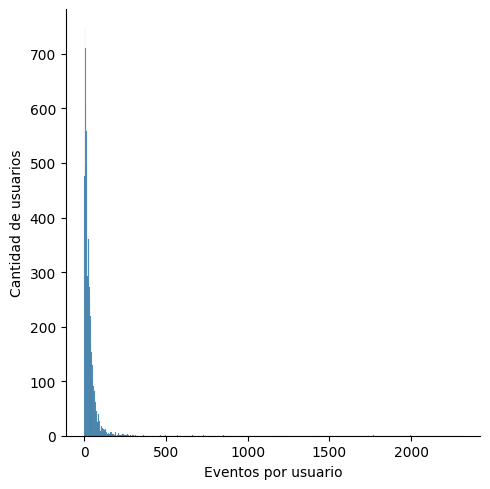

In [10]:
print(df.groupby('device_id')['event'].count().mean().round(0))
sns.displot(df.groupby('device_id')['event'].count())
plt.xlabel('Eventos por usuario')
plt.ylabel('Cantidad de usuarios');

Se descubre que la media es 32, sin embargo no estamos en presencia de una distribución normal, lo que significa que debemos usar otra medida como __la moda__.

0    5
dtype: int64



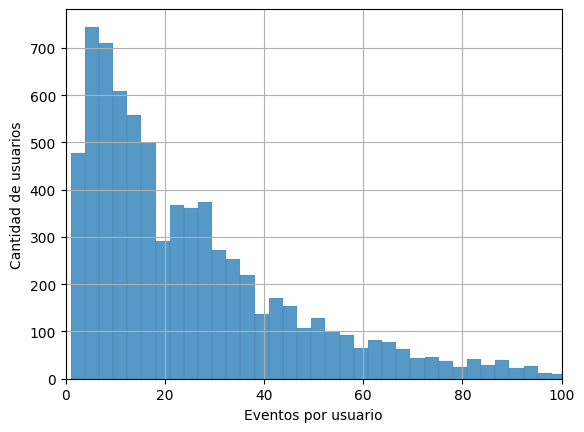

In [11]:
print(df.groupby('device_id')['event'].count().mode())
print()
sns.histplot(df.groupby('device_id')['event'].count())
plt.xlim(0, 100)
plt.grid(True)
plt.xlabel('Eventos por usuario')
plt.ylabel('Cantidad de usuarios');

Obtenemos la moda y verificamos mediante el nuevo histograma, se puede concluir que __un usuario promedio tiende a realizar 5 eventos__ en la web de la empresa.

#### ¿Qué periodo de tiempo cubren los datos?

Esta pregunta puede abordarse de varias maneras, se comenzará con la más simple.

In [12]:
print(df['date'].min())
print(df['date'].max())

2019-07-25
2019-08-07


Se identifican las fechas límite de los datos, cubren un rango de __dos semanas__. Ahora se analizará la distribución de los datos dentro de estas dos semanas estudiadas.

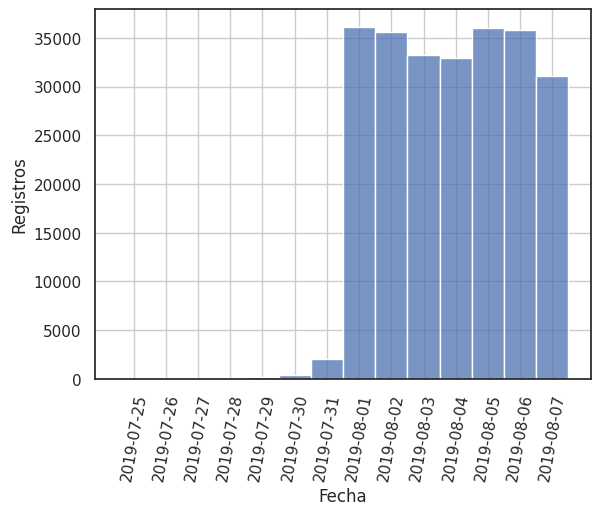

In [13]:
sns.set(style='white')
sns.histplot(data=df, x='date')
plt.grid(True)
plt.xticks(rotation=80)
plt.xlabel('Fecha')
plt.ylabel('Registros');

Se observa que tenemos datos completos desde el `2019-08-01` en adelante, un rango de __una semana__. Se eliminarán los datos de antes de la fecha indicada.

In [14]:
new_df = df[df['date'] >= '2019-08-01']

Se crea un nuevo dataset con la información filtrada por fecha el análisis, se comprobará si es significativa la cantidad de datos perdidos.

In [15]:
print('Total de eventos:' ,len(df))
print('Eventos perdidos:' ,len(df) - len(new_df))
print('Eventos perdidos:' ,((len(df) - len(new_df)) / len(df))*100, '%')
print()
print('Total de clientes:', df['device_id'].nunique())
print('Clientes perdidos:' ,df['device_id'].nunique() - new_df['device_id'].nunique())
print('Clientes perdidos:' ,(df['device_id'].nunique() - new_df['device_id'].nunique()) / df['device_id'].nunique(), '%')

Total de eventos: 243713
Eventos perdidos: 2826
Eventos perdidos: 1.159560630741897 %

Total de clientes: 7551
Clientes perdidos: 17
Clientes perdidos: 0.0022513574361011784 %


Se comprueba que __las pérdidas de información son mínimas__, sobre todo en cuanto a registros de clientes (que es en lo que más se trabajará).

#### ¿Hay una cantidad suficiente de registros por grupo?

Mediante un gráfico de barras se comprobará si hay una cantidad suficiente de registros por grupo.

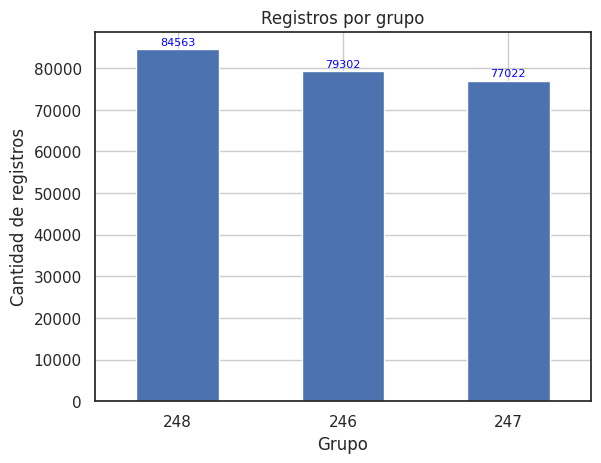

In [16]:
ax = new_df['group'].value_counts().plot(kind='bar', rot=0, grid=True, xlabel='Grupo', ylabel='Cantidad de registros', title='Registros por grupo')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='blue');

Efectivamente __hay una cantidad significativa de registros por grupo__.

### Estudiar el embudo de eventos

En esta fase se estudiará el embudo de eventos para analizar el comportamiento de los usuarios en la web de la compañía.

#### ¿Qué eventos hay en los registros? y ¿Cuál su frecuencia de suceso?

Mediante un filtrado y un gráfico de barras con etiquetas se graficarán los registros y su determinada frecuencia.

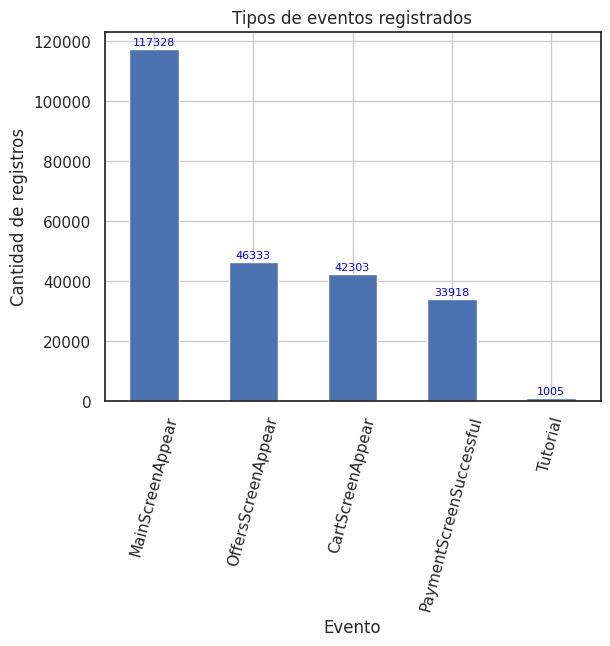

In [17]:
ax = new_df['event'].value_counts().plot(kind='bar', rot=75, grid=True, xlabel='Evento', ylabel='Cantidad de registros', title='Tipos de eventos registrados')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='blue');

Hay 5 tipos de evento registrados:
- Aparición de pantalla principal.
- Aparición de pantalla de ofertas.
- Aparición de pantalla de carrito.
- Aparición de pantalla de Pago exitoso.
- Tutorial.

Están distribuídas en orden lógico exceptuando la etapa `Tutorial` la cual debe ser una guía de como hacer una compra, esto tiene sentido debido a que esto se suele omitir, lo que explicaría una cantidad tan baja de registros de este evento. Se probará más adelante esta teoría.

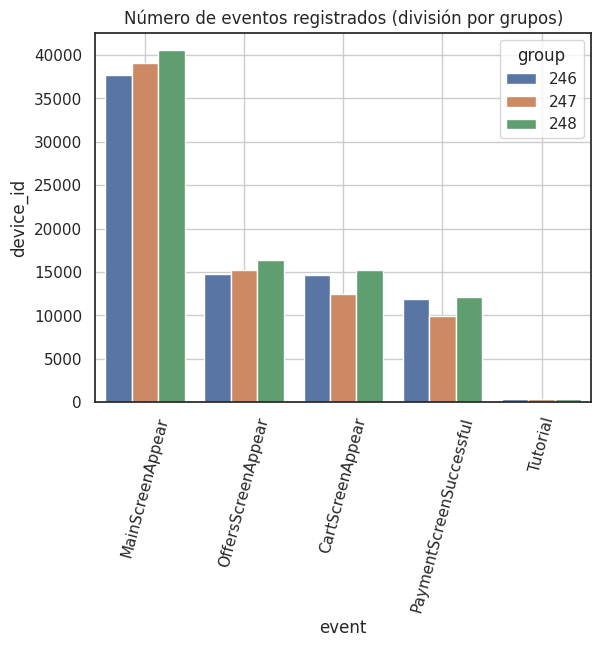

In [18]:
bar = new_df.groupby(['event', 'group'])['device_id'].count().reset_index()
sns.barplot(data=bar, x='event', y='device_id', hue='group', order=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'])
plt.xticks(rotation=75)
plt.title('Número de eventos registrados (división por grupos)')
plt.grid(True)

En cuanto al gráfico desglosado por grupos, __se observa al grupo 248 (grupo B) levemente superior a los otros dos grupos__.

#### ¿Cual la cantidad de usuarios y usuarias que realizaron cada una de las acciones registradas?

De la misma manera que en el paso anterior (filtrando y graficando) se obtendrá la cantidad de usuarios que realizaron cada acción.

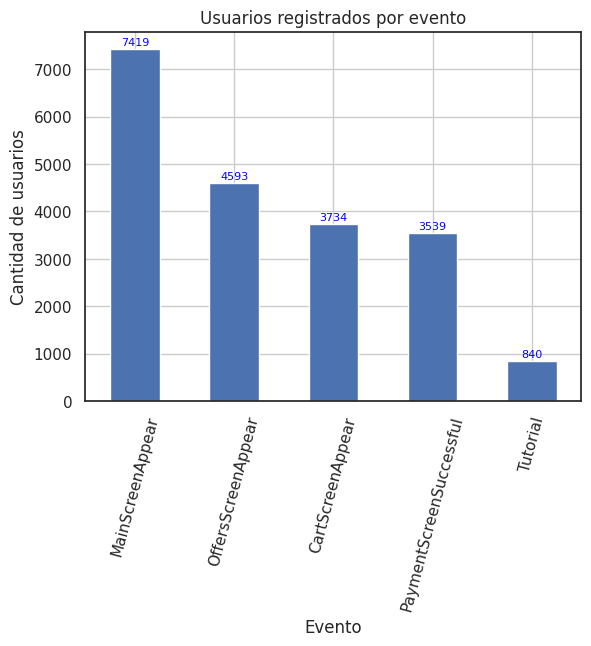

In [19]:
ax = new_df.groupby('event')['device_id'].nunique().sort_values(ascending=False).plot(kind='bar', rot=75, grid=True, xlabel='Evento', ylabel='Cantidad de usuarios', title='Usuarios registrados por evento')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='blue');

Las proporciones de usuarios por evento coinciden con el gráfico anterior, sin embargo, la diferencia entre la pantalla principal y la pantalla de oferta es menor que en el gráfico de eventos, esto significa que __los usuarios tienden a visitar la pantalla principal muchas veces antes de concretar una compra__ (se puede seguir profundizando en esto).

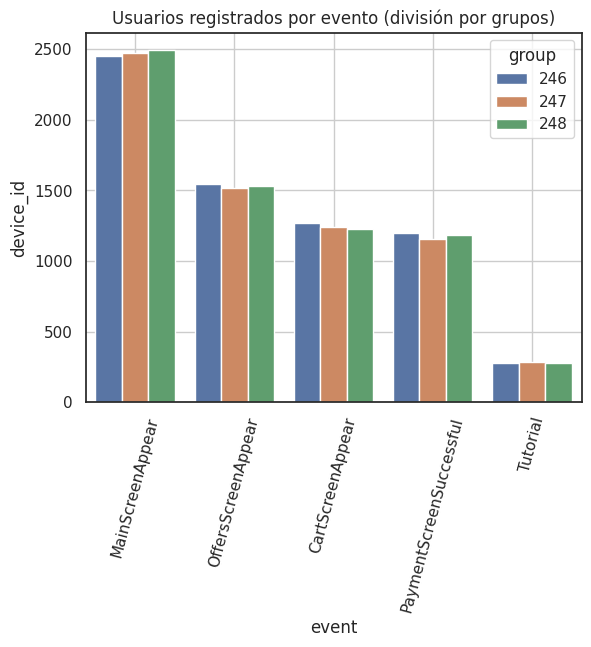

In [20]:
bar = new_df.groupby(['event', 'group'])['device_id'].nunique().reset_index()
sns.barplot(data=bar, x='event', y='device_id', hue='group', order=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'])
plt.xticks(rotation=75)
plt.title('Usuarios registrados por evento (división por grupos)')
plt.grid(True)

En cuanto al desglose por grupos, podemos darnos cuenta de que __la cantidad de usuarios por grupo esta muy pareja__.

#### ¿En qué orden ocurrieron las acciones?

Ahora se comprobará el orden de las acciones, para ello, se extraerán dos id de dispositivo que hayan completado el tutorial y se observará la cronología de eventos que completaron en la web.

In [21]:
new_df.query('event == "Tutorial"')

,event,device_id,ts,group,date,hour
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01,00:07
2841,Tutorial,3737462046622621720,1564618338,246,2019-08-01,00:12
3353,Tutorial,5587388800188073787,1564625981,247,2019-08-01,02:19
3433,Tutorial,2988069914968447512,1564626904,246,2019-08-01,02:35
3590,Tutorial,1884616937397676465,1564628471,247,2019-08-01,03:01
...,...,...,...,...,...,...
241781,Tutorial,1309234519709630135,1565204899,247,2019-08-07,19:08
241869,Tutorial,5523029501947287934,1565205070,247,2019-08-07,19:11
242673,Tutorial,4069063897900929368,1565206705,248,2019-08-07,19:38
242695,Tutorial,5862484110925354625,1565206785,247,2019-08-07,19:39


Se seleccionarán las id de dispositivo `3737462046622621720` y `1309234519709630135`.

In [22]:
new_df.query('device_id == 3737462046622621720')

,event,device_id,ts,group,date,hour
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01,00:07
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01,00:08
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01,00:08
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01,00:08
2834,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01,00:10
2835,MainScreenAppear,3737462046622621720,1564618247,246,2019-08-01,00:10
2836,MainScreenAppear,3737462046622621720,1564618270,246,2019-08-01,00:11
2837,MainScreenAppear,3737462046622621720,1564618280,246,2019-08-01,00:11
2841,Tutorial,3737462046622621720,1564618338,246,2019-08-01,00:12
2842,MainScreenAppear,3737462046622621720,1564618354,246,2019-08-01,00:12


En este caso __el Tutorial es efectivamente el primer evento completado__, vamos a analizar ahora la segunda id que es de una fecha diferente.

In [23]:
new_df.query('device_id == 1309234519709630135')

,event,device_id,ts,group,date,hour
241781,Tutorial,1309234519709630135,1565204899,247,2019-08-07,19:08
241823,MainScreenAppear,1309234519709630135,1565204960,247,2019-08-07,19:09
241843,MainScreenAppear,1309234519709630135,1565205001,247,2019-08-07,19:10
241844,OffersScreenAppear,1309234519709630135,1565205005,247,2019-08-07,19:10
241877,CartScreenAppear,1309234519709630135,1565205090,247,2019-08-07,19:11
242317,PaymentScreenSuccessful,1309234519709630135,1565205997,247,2019-08-07,19:26
242341,OffersScreenAppear,1309234519709630135,1565206016,247,2019-08-07,19:26
242361,OffersScreenAppear,1309234519709630135,1565206049,247,2019-08-07,19:27
242366,OffersScreenAppear,1309234519709630135,1565206057,247,2019-08-07,19:27
242558,OffersScreenAppear,1309234519709630135,1565206420,247,2019-08-07,19:33


En el segundo caso el también el tutorial es el primer evento completado, por lo que el orden de eventos sería el siguiente:
- __Tutorial (opcional)__.
- __Pantalla principal__.
- __Pantalla de oferta__.
- __Pantalla de carrito__.
- __Pago exitoso__.

#### ¿Cual es la proporción de usuarios y usuarias que pasan de una etapa a la siguiente?

Para trabajar con esta métrica se debe, primero, tener presente el número total de usuarios registrados en el nuevo dataset filtrado.

In [24]:
new_df['device_id'].nunique()

7534

Hay __7534 usuarios y registrados__ en el nuevo dataset. Ahora se construirá un gráfico de embudo con los porcentajes visibles para cada evento respecto del total y respecto de la etapa anterior.

In [25]:
fig = go.Figure(go.Funnel(
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [7419, 4593, 3734, 3539],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"
    ))

(Se adjunta una foto debido a que la librería `Figure` de gráficos interactivos, necesita tener el kernel funcionando para mostrar la visualización, debido a eso, una imagen adjunta es más práctico.)

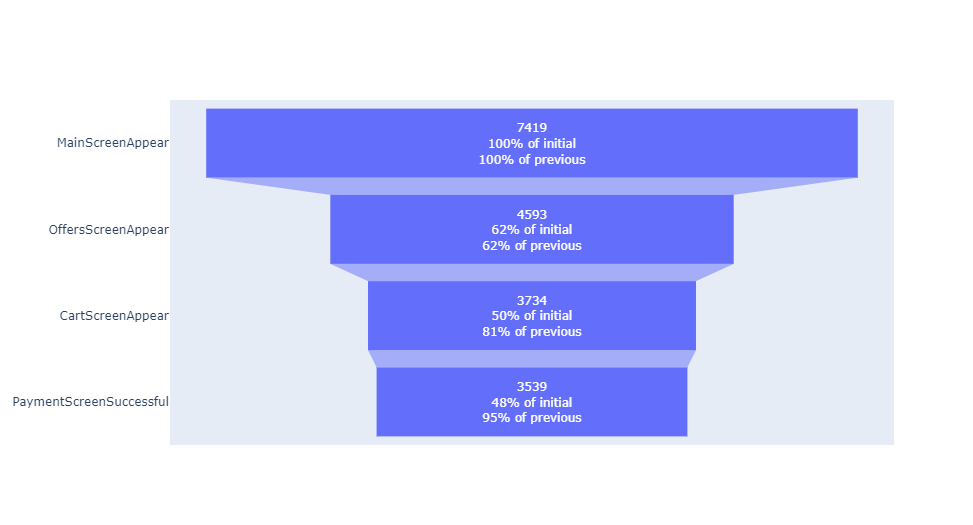

Comparandolo con otros embudos de ventas, este se ve muy bien, ya que __un 48% de los usuarios completó el Funnel hasta el pago__. Analizando las pérdidas se puede apreciar que donde más se pierden usuarios es en la transición de __la pantalla inicial a la pantalla de oferta, donde abandona el 38% de los usuarios__ que ven la pantalla inicial. 

Ahora visualizaremos el mismo funnel, pero con divisiones por grupos, para esto debemos comenzar crando un dataset agrupado por evento, por cada grupo de prueba.

In [40]:
g246 = new_df[new_df['group'] == 246].groupby('event')['device_id'].nunique().sort_values(ascending=False).reset_index()
g247 = new_df[new_df['group'] == 247].groupby('event')['device_id'].nunique().sort_values(ascending=False).reset_index()
g248 = new_df[new_df['group'] == 248].groupby('event')['device_id'].nunique().sort_values(ascending=False).reset_index()
g246

,event,device_id
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200
4,Tutorial,278


Una vez listos los datasets, podemos generar la visualización.

In [43]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    meta = g246,
    y = g246['event'],
    x = g246['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"
    ))

fig.add_trace(go.Funnel(
    name = '247',
    meta = g247,
    y = g247['event'],
    x = g247['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"
    ))

fig.add_trace(go.Funnel(
    name = '248',
    meta = g248,
    y = g248['event'],
    x = g248['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"
    ))

plt.close()

(Se adjunta una foto debido a que la librería `Figure` de gráficos interactivos, necesita tener el kernel funcionando para mostrar la visualización, debido a eso, una imagen adjunta es más práctico.)

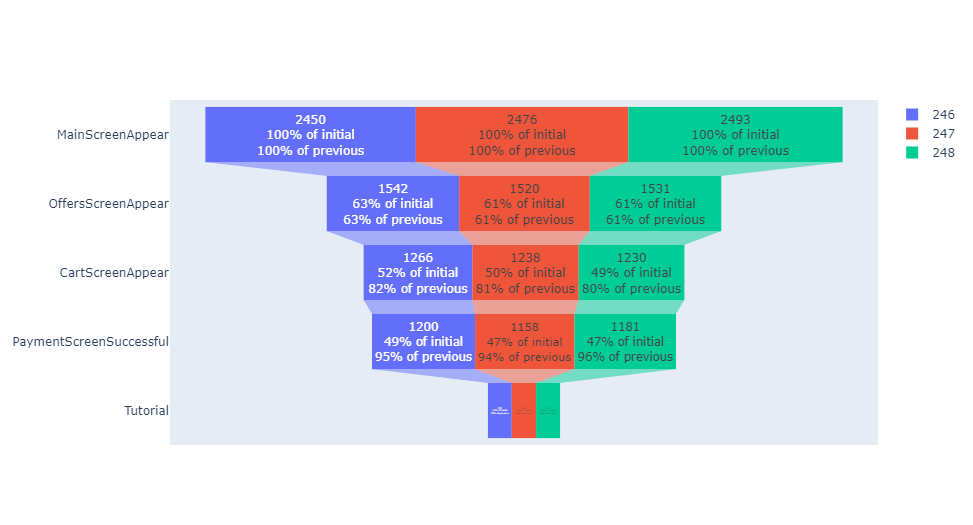

El nuevo gráfico nos muestra lo mismo que habíamos visto en los gráficos de barras anteriores, __las tasas de conversión son muy parecidas entre los grupos__. Las diferencias observadas oscilan entre un 1% y un 2% lo que, probablemente, no sea suficiente para que sean estadísticamente significativas, de todas maneras, se realizarán las pruebas correspondientes.

### Estudiar los resultados del experimento

En esta fase se estudiarán los resultados del test A/A/B que se mencionó al principio del informe, mediante los grupos de control se comprobará si la muestra fue aislada correctamente y en el caso que así sea, mediante el grupo de prueba se comprobará si los cambios en la fuente de la aplicación modifican el comportamiento de los usuarios.

#### ¿Cuántos usuarios y usuarias hay en cada grupo?

Antes de hacer pruebas estadísticas necesitamos saber cuántos usuarios hay en cada grupo.

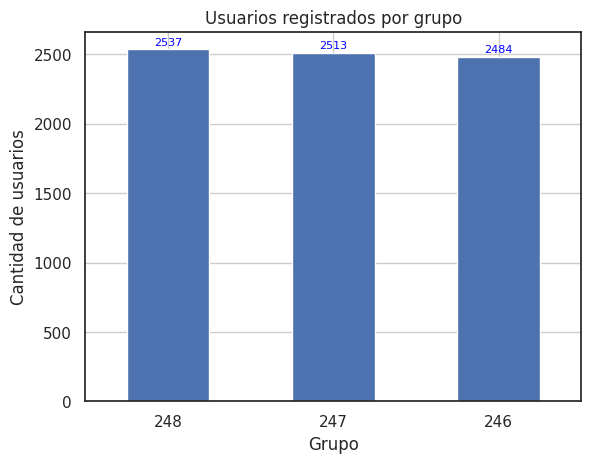

In [28]:
ax = new_df.groupby('group')['device_id'].nunique().sort_values(ascending=False).plot(kind='bar', rot=0, grid=True, xlabel='Grupo', ylabel='Cantidad de usuarios', title='Usuarios registrados por grupo')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='blue');

Las cantidades son muy similares entre los grupos y hay suficientes usuarios para poder tener resultados significativos.

#### ¿Hay una diferencia estadísticamente significativa entre los grupos de control?

Ahora se comprobará, mediante una prueba estadística sobre las proporciones de usuarios que hacen compras y los que no, si es que hay diferencias entre los grupos de control (`246` y `247`).

In [29]:
conversions = new_df[['device_id', 'group']].drop_duplicates() #Se crea una matriz de id de dispositivo y grupos, para evitar duplicados
converted = pd.DataFrame(data={"device_id": new_df[new_df["event"] == "PaymentScreenSuccessful"]["device_id"].unique(), "converted": 1}) #Se crea un dataframe donde cada usuario que hizo al menos una compra tiene un booleano de 1
conversions = conversions.merge(converted, on="device_id", how="left")
conversions["converted"] = conversions["converted"].fillna(0)
conversions.head()

,device_id,group,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0


Lo primero que se hizo aquí es crear una matriz de `device_id` y grupos, para hacer la division por grupos entre los usuarios y eliminar la posibilidad de que un mismo id esté en más de un grupo, luego se crea un dataset donde cada `device_id` que hizo al menos una compra, tiene en la columna `converted` un booleano 1, finalmente se combina con la matriz quedando todos los id que no hicieron compras como valores ausentes, estos se rellenan con ceros quedando lista la clasificación por compra por cliente.

Ahora solo queda aplicar la formula para la prueba estadística.

In [30]:
alpha = .05 #  nivel de significación

purchases = np.array([len(conversions.query('group == 246 and converted == 1')), len(conversions.query('group == 247 and converted == 1'))])
leads = np.array([len(conversions.query('group == 246')), len(conversions.query('group == 247'))])

print(purchases)
print(leads)

p1 = purchases[0]/leads[0]
p2 = purchases[1]/leads[1]
p_combined = ((purchases[0] + purchases[1]) / (leads[0] + leads[1]))
difference = p1 - p2

print('246:', format(p1, '.2%'), '%  ','247:',format(p2, '.2%'), '%.')

z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2 

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

[1200 1158]
[2484 2513]
246: 48.31% %   247: 46.08% %.
p-value:  0.11456679313141849
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


La prueba estadística concluye que __no hay diferencias significativas entre la tasa de conversión de los grupos de control__.

#### ¿Qué conclusiones se pueden sacar del experimento?

Para poder sacar conclusiones del experimiento, se definirá una función para calcular las diferencias estadísticas entre los eventos y los grupos del dataset, el cálculo anterior ayudará a corroborar que la función trabaje adecuadamente.

In [31]:
def prop_test(group_1, group_2, event):
    
    conversions = new_df[['device_id', 'group']].drop_duplicates()
    converted = pd.DataFrame(data={"device_id": new_df[new_df["event"] == event]["device_id"].unique(), "converted": 1})
    conversions = conversions.merge(converted, on="device_id", how="left")
    conversions["converted"] = conversions["converted"].fillna(0)
    
    purchases = np.array([len(conversions[(conversions['group'] == group_1) & (conversions['converted'] == 1)]), 
                          len(conversions[(conversions['group'] == group_2) & (conversions['converted'] == 1)])])
                          
    leads = np.array([len(conversions[conversions['group'] == group_1]), 
                      len(conversions[conversions['group'] == group_2])])
    
    print(event, ':',purchases)
    print('Total :',leads)
    
    alpha = .05 / 5 #Corrección de Bonferroni
    
    p1 = purchases[0]/leads[0]
    p2 = purchases[1]/leads[1]
    p_combined = ((purchases[0] + purchases[1]) / (leads[0] + leads[1]))
    difference = p1 - p2
    
    print(group_1, ':', format(p1, '.2%'), '%  ', group_2, ':', format(p2, '.2%'), '%.')

    z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

La función está lista, incorpora todas las salidas y los pasos de la formula, se establece un valor alpha de `.05 / 5` ya que estamos aplicando __la correción de Bonferroni__ para disminuir la probabilidad de error en las múltiples pruebas estadísticas ( se divide por cinco porque son cinco eventos registrados). Funciona proporcionando los grupos a comparar y el nombre del evento, para verificar que funcione bien se observará el resultado del evento `PaymentScreenSuccessful`.

Se aplicará la función, primero, entre los grupos de control (`246` y `247`)

In [32]:
prop_test(246, 247, 'MainScreenAppear')
print()
prop_test(246, 247, 'OffersScreenAppear')
print()
prop_test(246, 247, 'CartScreenAppear')
print()
prop_test(246, 247, 'PaymentScreenSuccessful')
print()
prop_test(246, 247, 'Tutorial')

MainScreenAppear : [2450 2476]
Total : [2484 2513]
246 : 98.63% %   247 : 98.53% %.
p-value:  0.7570597232046099
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

OffersScreenAppear : [1542 1520]
Total : [2484 2513]
246 : 62.08% %   247 : 60.49% %.
p-value:  0.2480954578522181
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

CartScreenAppear : [1266 1238]
Total : [2484 2513]
246 : 50.97% %   247 : 49.26% %.
p-value:  0.22883372237997213
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

PaymentScreenSuccessful : [1200 1158]
Total : [2484 2513]
246 : 48.31% %   247 : 46.08% %.
p-value:  0.11456679313141849
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Tutorial : [278 283]
Total : [2484 2513]
246 : 11.19% %   247 : 11.26% %.
p-value:  0.9376996189257114
No se pudo rechazar la hipótes

La función opera correctamente, ya que el resultado de `PaymentScreenSuccessful` coincide con el del ejercicio anterior.

Además se observa que __los grupos de control están bien divididos__, que no hay diferencias estadísticas en ninguno de los eventos, se observan valores p relativamente altos y variaciones bajas en los porcentajes.

Ahora se hará la comparación con el grupo de prueba (`248`) para determinar si los cambios de fuente en la aplicación generan resultados positivos, neutrales o negativos. Se mantendrá la funcion con el valor alpha de `.05 / 5` ya que, aunque ahora sean más pruebas estadisticas, los grupos a comparar se repiten, de igual manera, cinco veces (una por cada evento)

In [33]:
prop_test(246, 248, 'MainScreenAppear')
print()
prop_test(247, 248, 'MainScreenAppear')

MainScreenAppear : [2450 2493]
Total : [2484 2537]
246 : 98.63% %   248 : 98.27% %.
p-value:  0.2949721933554552
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

MainScreenAppear : [2476 2493]
Total : [2513 2537]
247 : 98.53% %   248 : 98.27% %.
p-value:  0.4587053616621515
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


- __No hay diferencia significativa en el evento de muestra de pantalla principal.__

In [34]:
prop_test(246, 248, 'OffersScreenAppear')
print()
prop_test(247, 248, 'OffersScreenAppear')

OffersScreenAppear : [1542 1531]
Total : [2484 2537]
246 : 62.08% %   248 : 60.35% %.
p-value:  0.20836205402738917
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

OffersScreenAppear : [1520 1531]
Total : [2513 2537]
247 : 60.49% %   248 : 60.35% %.
p-value:  0.9197817830592261
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


- __No hay diferencia significativa en el evento de muestra de pantalla de oferta.__

In [35]:
prop_test(246, 248, 'CartScreenAppear')
print()
prop_test(247, 248, 'CartScreenAppear')

CartScreenAppear : [1266 1230]
Total : [2484 2537]
246 : 50.97% %   248 : 48.48% %.
p-value:  0.07842923237520116
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

CartScreenAppear : [1238 1230]
Total : [2513 2537]
247 : 49.26% %   248 : 48.48% %.
p-value:  0.5786197879539783
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


- __No hay diferencia significativa en el evento de muestra de pantalla de carrito.__

In [36]:
prop_test(246, 248, 'PaymentScreenSuccessful')
print()
prop_test(247, 248, 'PaymentScreenSuccessful')

PaymentScreenSuccessful : [1200 1181]
Total : [2484 2537]
246 : 48.31% %   248 : 46.55% %.
p-value:  0.2122553275697796
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

PaymentScreenSuccessful : [1158 1181]
Total : [2513 2537]
247 : 46.08% %   248 : 46.55% %.
p-value:  0.7373415053803964
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


- __No hay diferencia significativa en el evento de muestra de pago exitoso.__

In [37]:
prop_test(246, 248, 'Tutorial')
print()
prop_test(247, 248, 'Tutorial')

Tutorial : [278 279]
Total : [2484 2537]
246 : 11.19% %   248 : 11.00% %.
p-value:  0.8264294010087645
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Tutorial : [283 279]
Total : [2513 2537]
247 : 11.26% %   248 : 11.00% %.
p-value:  0.765323922474501
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


- __No hay diferencia significativa en el evento de muestra de tutorial.__

Del experimento se concluye que los cambios en la fuente de la aplicación propuestos por el equipo de diseño __no dieron resultados positivos ni tampoco negativos, estadísticamente hablando__, mirando los porcentajes se puede apreciar que estuvieron levemente por debajo de los grupos de control, por lo cual, __no se recomienda hacer los cambios propuestos__.

#### ¿El nivel de significación ha sido el correcto?

Si, en una primera instancia se realizaron todas las pruebas con un nivel de significación de `.05` y los resultados fueron los mismos, __debido a que los valores p son altos (la probabilidad de que sean iguales es muy alta) no habrá variaciones en los resultados al bajar el nivel de significación, de igual manera se aplica la corrección de Bonferroni, ya que es la manera correcta de aplicar las pruebas estadísticas__ en estos casos por la manera en que disminuye las probabilidades de un falso positivo.

In [38]:
print('Probabilidad de falso positivo sin corrección:' ,format(1 - (1 - 0.05)**5, '.2%'))
print()
print('Probabilidad de falso positivo con corrección:',format(1 - (1 - (0.05 / 5))**5, '.2%'))

Probabilidad de falso positivo sin corrección: 22.62%

Probabilidad de falso positivo con corrección: 4.90%


Una drástica disminución (17%) de las probabilidades de falla se observa en este caso.

## Conclusiones

En este apartado se desarollarán ampliamente todas las conclusiones obtenidas en el desarrollo del informe, haciendo hincapié en los hallazgos fundamentales del trabajo, como lo son: hallazgos sobre el registro de los datos, información sobre el embudo de eventos, relevancia de los hallazgos y conclusiones sobre el experimento.

### Estudio y comprobación de los datos

- Se calculó la cantidad de datos por día y se determinó que __hay una cantidad suficiente de datos (eventos, registros de grupo y usuario) para realizar un análisis y pruebas estadísiticas__.
- Se observó que __hay datos completos desde el 2019-08-01 en adelante, un rango de una semana__. Se eliminaron los datos de antes de la fecha indicada.

### Embudo de eventos

Hay 5 tipos de evento registrados:
- Aparición de pantalla principal.
- Aparición de pantalla de ofertas.
- Aparición de pantalla de carrito.
- Aparición de pantalla de Pago exitoso.
- Tutorial.

__El tutorial es un opcional que está en la parte superior del embudo__ y que la gran mayoría elige saltar (no quita que pueda ser muy útil para la gente que elige verlo). En cuanto a las hallazgos sobre el paso de los clientes por el embudo, hemos detectado que:
- Los usuarios suelen visitar __más de una vez la pantalla principal antes de hacer una compra__.
- En donde más se pierden usuarios es __en la transición de pantalla principal a pantalla de oferta__ (un 38%).

### Experimento

En cuanto al experimento, podemos rescatar que el segmento A/A del test, fue realizado correctamente, ya que no se apreciaron diferencias significativas entre estos grupos. En cuanto al resultado final (como se menciona anteriormente) se concluye que:

__No se recomienda implementar el cambio del grupo B, ya que no se rechaza ninguna hipótesis nula en favor de este grupo y, en porcentajes está ligeramente por debajo de los grupos A.__